In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [6]:
x = torch.randn(10)

In [7]:
x.expand?

Docstring:
expand(*sizes) -> Tensor

Returns a new view of the tensor with singleton dimensions expanded
to a larger size.

Passing -1 as the size for a dimension means not changing the size of
that dimension.

Tensor can be also expanded to a larger number of dimensions, and the
new ones will be appended at the front. (For the new dimensions, the
size cannot be set to -1.)

Expanding a tensor does not allocate new memory, but only creates a
new view on the existing tensor where a dimension of size one is
expanded to a larger size by setting the ``stride`` to 0. Any dimension
of size 1 can be expanded to an arbitrary value without allocating new
memory.

Args:
    *sizes (torch.Size or int...): The desired expanded size

Example:
    >>> x = torch.Tensor([[1], [2], [3]])
    >>> x.size()
    torch.Size([3, 1])
    >>> x.expand(3, 4)
     1  1  1  1
     2  2  2  2
     3  3  3  3
    [torch.FloatTensor of size 3x4]
    >>> x.expand(-1, 4)   # -1 means not changing the size of that dime

In [4]:
train_data = datasets.MNIST('~/learn/4sem/deep/mnist', train=True, download=True)
test_data = datasets.MNIST('~/learn/4sem/deep/mnist', train=False, download=True)

In [5]:
X_train = train_data.train_data.numpy()[:, None, :, :]
y_train = train_data.train_labels.numpy()
X_test = test_data.test_data.numpy()[:, None, :, :]
y_test = test_data.test_labels.numpy()

In [6]:
X_train = X_train.astype(float) / X_train.max()
X_test = X_test.astype(float) / X_test.max()

In [7]:
class TripleBatchGen:
    def __init__(self, X, y):
        self.X = X
        self.yvals = np.unique(y)
        self.yids = dict()
        for yval in self.yvals:
            self.yids[yval] = np.where(y == yval)[0]
            
    def generate_batches(self, batch_size, n_batches):
        for _ in range(n_batches):
            an_label = np.random.choice(list(self.yids.keys()))
            np.random.shuffle(self.yids[an_label])
            an_ids = self.yids[an_label][:batch_size]
            pos_ids = self.yids[an_label][batch_size: 2 * batch_size]
            neg_label = an_label
            while neg_label == an_label:
                neg_label = np.random.choice(list(self.yids.keys()))
            neg_ids = self.yids[neg_label][np.random.randint(0, len(self.yids[neg_label]), batch_size)]
            yield self.X[an_ids], self.X[pos_ids], self.X[neg_ids]
            
def simple_batch_gen(X, y, batch_size, epoch_size):
    X = X[y < 2]
    y = y[y < 2]
    for _ in range(epoch_size):
        ids = np.random.randint(0, len(y), batch_size)
        yield X[ids], y[ids]

In [8]:
class HistoryContainer():
    def __init__(self, alpha=0.99):
        self.alpha = alpha
        self.container = []
        
    def append(self, value):
        if not self.container:
            self.container.append(value)
        else:
            self.container.append(
                self.alpha * self.container[-1] +
                (1 - self.alpha) * value)

In [9]:
batch_gen = TripleBatchGen(X_train, y_train)

In [10]:
class DConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DConv, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = DConv(1, 16)
        self.conv2 = DConv(16, 32)
        self.fc1 = nn.Linear(1568, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.max_pool2d(self.conv2(x), 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return self.fc3(x)

In [11]:
net = Net().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.TripletMarginLoss()

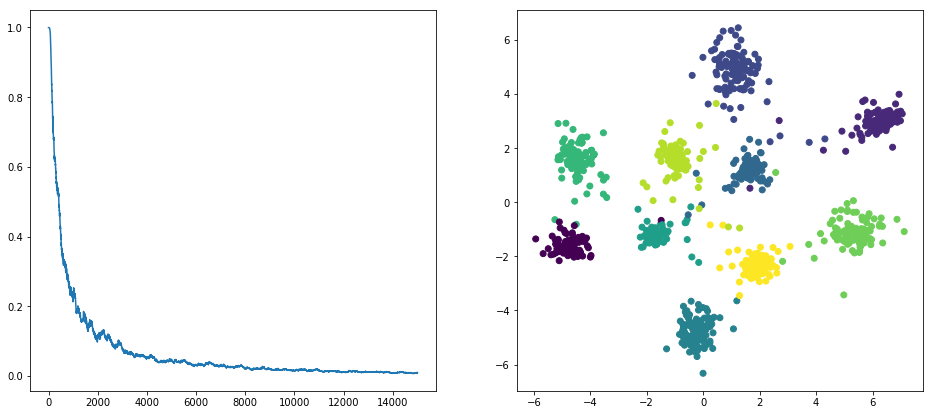

In [12]:
batch_size = 200
epoch_size= 100
n_epochs = 150
train_loss = HistoryContainer()
for epoch in range(n_epochs):
    net.train()
    for Xanch, Xtrue, Xfalse in batch_gen.generate_batches(batch_size, epoch_size):
        optimizer.zero_grad()
        Xbatch = np.concatenate((Xanch, Xtrue, Xfalse), axis=0)
        out = net(Variable(torch.FloatTensor(Xbatch).cuda()))
        loss = criterion(out[:batch_size], out[batch_size: 2 * batch_size], out[2 * batch_size:])
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data.cpu().numpy()[0])
    net.eval()
    Xbatch = X_test[:1000]
    ys = y_test[:1000]
    out = net(Variable(torch.FloatTensor(Xbatch).cuda(), volatile=True)).data.cpu().numpy()
    display.clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    ax[0].plot(train_loss.container)
    ax[1].scatter(out[:, 0], out[:, 1], c=ys)
    plt.show()

In [13]:
out.shape

(1000, 2)